In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd

# import custom functions
from corrmat_functions import *

In [2]:
corrmats = load_all_corrmats()
tickers = load_corrmat_tickers()

In [3]:
#creating dictionary with not null corrleation matrices
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

notnull_corrmats = {}
for key in  corrmats.keys():
    notnullcorrmat, notnullcorrmat_tickers = notnull_corrmat_and_tickers(corrmats[key], tickers)
    notnull_corrmats[key] = {'corrmat' : notnullcorrmat, 'tickers' : notnullcorrmat_tickers}

In [4]:
def print_notnull_corrmats(notnull_corrmats):
    print_corrmats({x[0]:x[1]['corrmat'] for x in notnull_corrmats.items()})

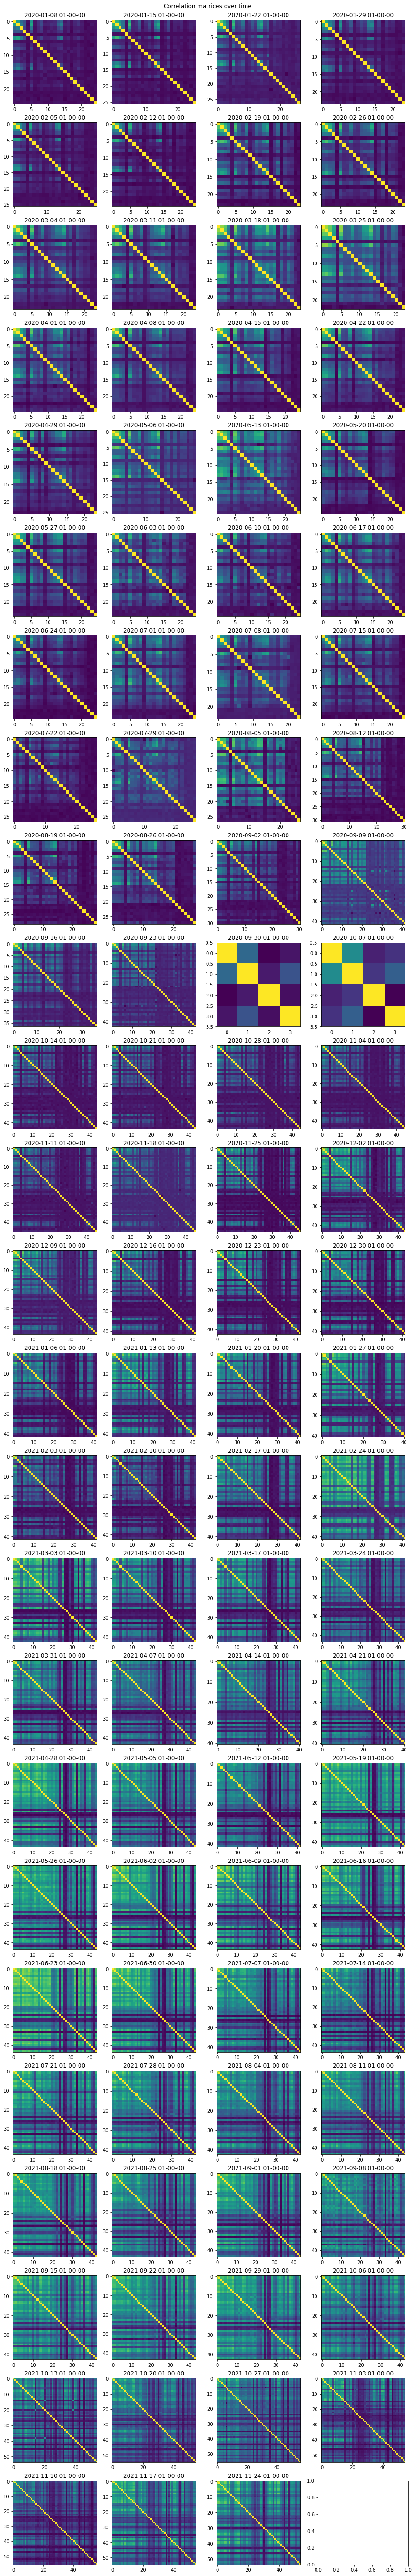

In [5]:
print_notnull_corrmats(notnull_corrmats)

In [90]:
#loading Q values
Qs_theory = np.load('data/Qs_theory.npy', allow_pickle='TRUE').item()

In [7]:
#takes a correlation matrix, Q , sigma and returns the denoised and rescaled correlation matrix

def get_denoised_correlation(correlation_matrix, Q, sigma):
    eigen_values, eigen_vectors = np.linalg.eig(correlation_matrix)

    N = len(eigen_values)

    eigen_value_min = sigma**2 * (1 + 1/Q - 2 * np.sqrt(1/Q))
    eigen_value_max = sigma**2 * (1 + 1/Q + 2 * np.sqrt(1/Q))

    filtered_eigen_values = [(eigen_value_max + eigen_value_min) / 2 if x < eigen_value_max else x for x in eigen_values]
    filtered_eigen_values_norm = [x / sum(filtered_eigen_values) * N for x in filtered_eigen_values]

    Y = eigen_vectors @ np.diag(filtered_eigen_values_norm) @ np.linalg.inv(eigen_vectors)

    d = [1 / (np.sqrt(x)) for x in Y.diagonal()]
    D = np.diag(d)

    Y_rescaled = D @ Y @ D

    return Y_rescaled

In [91]:
#creating dictionary with denoised non null correlation matrices
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

denoised_notnull_corrmats = {}

for k,v in notnull_corrmats.items():
    denoised_notnull_corrmats[k] = {'corrmat': get_denoised_correlation(v['corrmat'], Qs_theory[k], 1), 'tickers': v['tickers']}

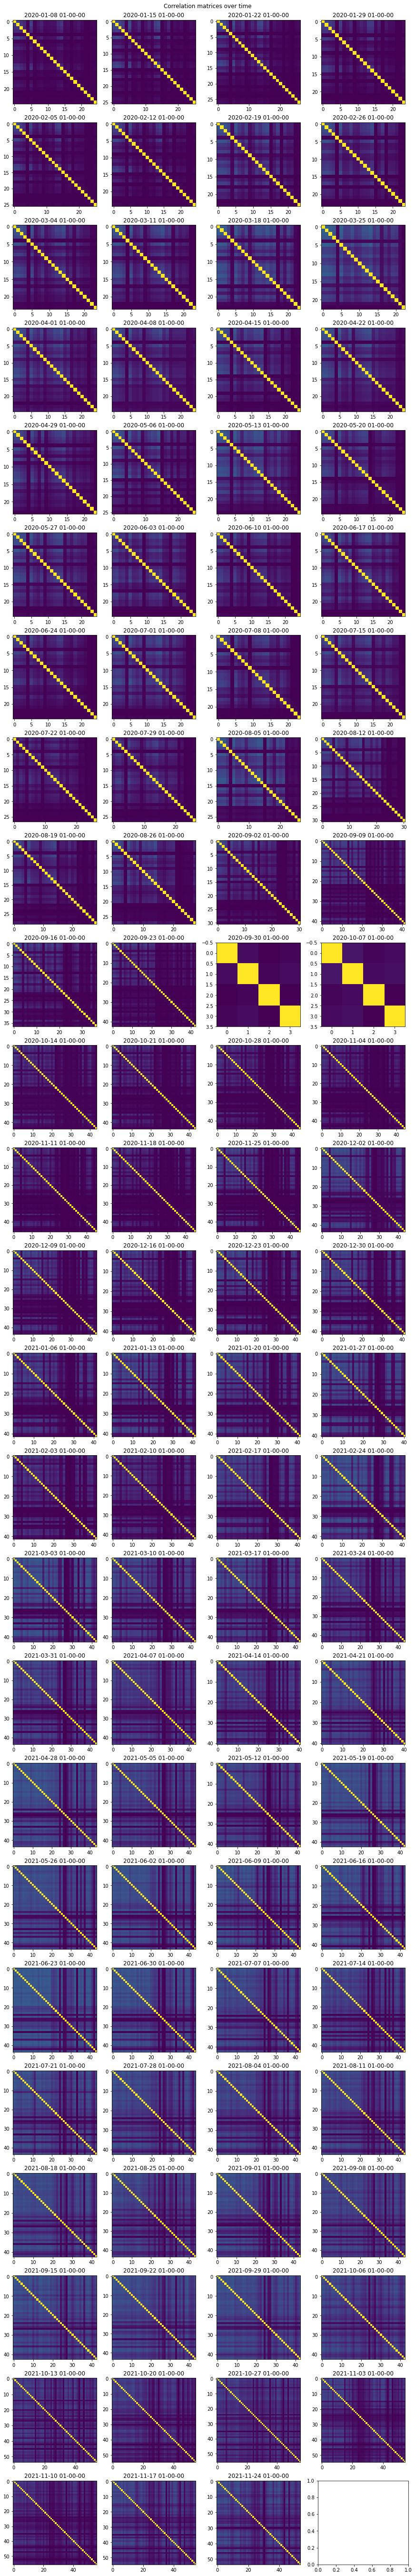

In [9]:
print_notnull_corrmats(denoised_notnull_corrmats)

In [10]:
#generating mst from item of correlation matrix dictionary
#input structure :
# { 
#   'corrmat' : <correleton_matrix>,
#   'tickers' : <tickers>
# }

def generate_mst(correlation_matrix):
    D = np.sqrt(2 * np.round((1 - correlation_matrix["corrmat"]), 15))
    np.fill_diagonal(D, 0)

    mst = nx.minimum_spanning_tree(nx.from_numpy_array(D))

    #creating dictionary with index as keys to set node attributes
    tickers = {index: stockname for index, stockname in enumerate(correlation_matrix["tickers"])}
    nx.set_node_attributes(mst, tickers , 'ticker')
    nx.get_node_attributes(mst, 'ticker')

    return mst

In [54]:
#creting dictionary with all msts
# dictionary structure:
# { <timestamp> : <mst> }

msts = {}

for k,v in denoised_notnull_corrmats.items():
    msts[k] = generate_mst(v)


In [55]:
#wanted to test some things out so I use also noisy msts

#creting dictionary with all msts that are not denoised
# dictionary structure:
# { <timestamp> : <mst> }

noisy_msts = {}

for k,v in notnull_corrmats.items():
    noisy_msts[k] = generate_mst(v)

In [64]:
#saving mst dictionaries to file

np.save('data/noisy_msts.npy', noisy_msts)
np.save('data/msts.npy', msts)

In [13]:
#plot the mst with node size and color based on degree

def plot_mst(mst, timestamp):
    plt.figure(figsize=(8, 5))
    node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
    node_size = [400 + nx.degree(mst)[n] * 20 for n in nx.nodes(mst)]
    pos = nx.kamada_kawai_layout(mst)
    #pos = nx.spring_layout(mst)
    nx.draw(mst, pos, node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=8)
    plt.title(f"{timestamp}")
    plt.show()

In [14]:
# print all msts with input dictionary as :
# { <timestamp> : <mst> }

def print_msts(msts, n_cols=4):
    T = len(msts.keys())

    # dimensions of figure/plot grid
    n_cols = 4
    n_rows = int(np.ceil(T/n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), constrained_layout=True)
    for cnt,timestamp in enumerate(sorted(msts.keys())):
        # determine axis
        col = cnt % n_cols
        row = cnt // n_cols
        ax = axs[row, col]

        # plot mst
        mst = msts[timestamp]

        node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
        node_size = [200 + nx.degree(mst)[n] * 10 for n in nx.nodes(mst)]
        #pos = nx.kamada_kawai_layout(mst)
        pos = nx.spring_layout(mst, k=0.1)
        nx.draw(mst, pos, ax=ax, node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=6)
        ax.set_title(timestamp)
        fig.suptitle("MSTs over time")

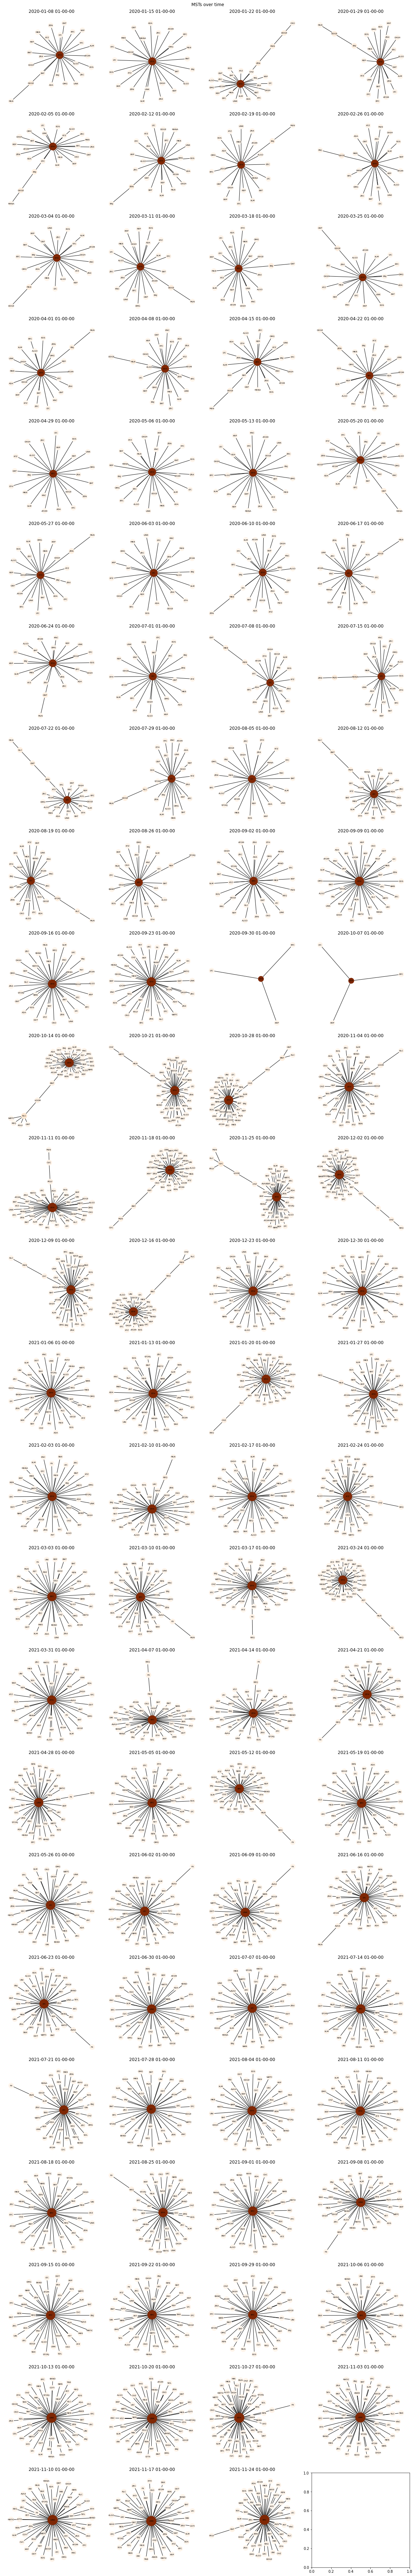

In [15]:
print_msts(msts)

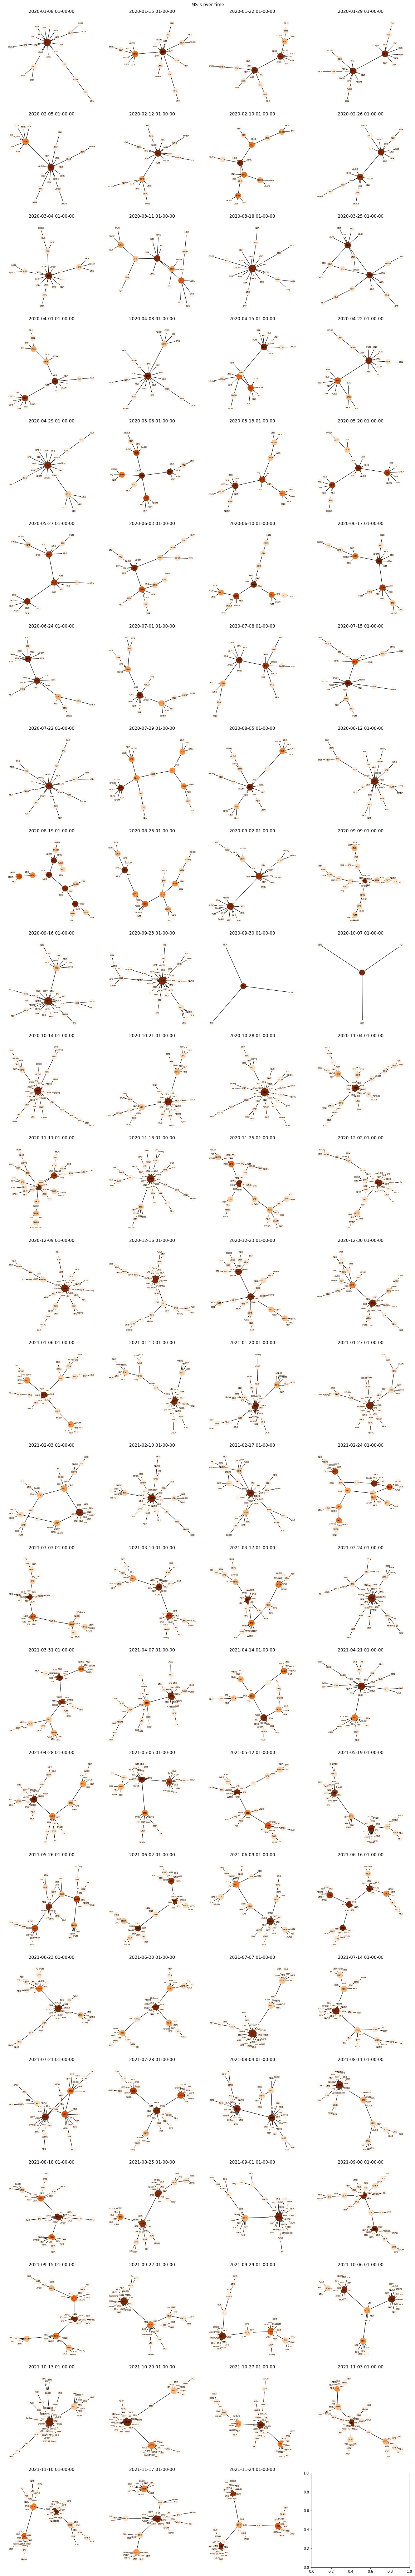

In [16]:
print_msts(noisy_msts)

[1, 23, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


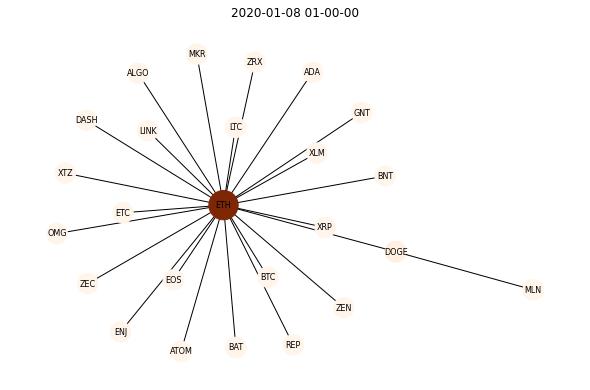

[1, 25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


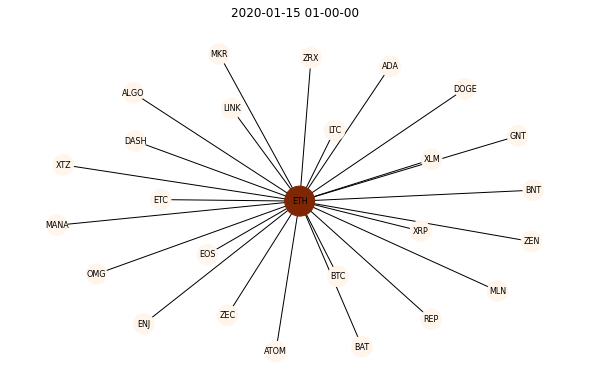

[1, 23, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1]


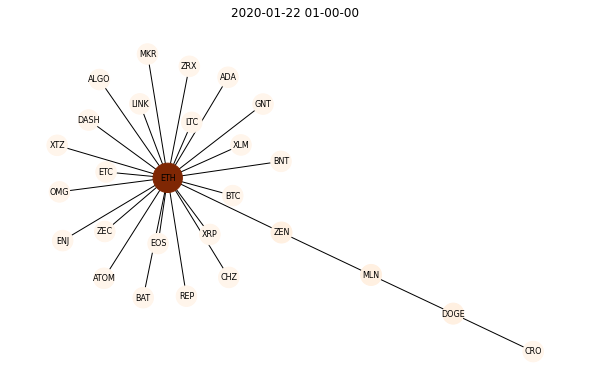

[1, 21, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]


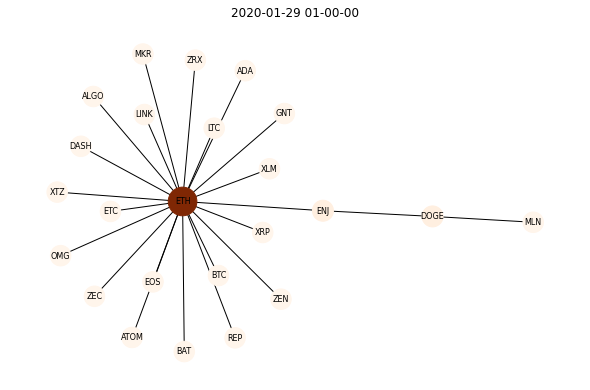

In [56]:
for k,mst in sorted(msts.items()):
    if k < "2020-02":
        print([x[1] for x in nx.degree(mst)])
        plot_mst(mst,k)


[2, 16, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]


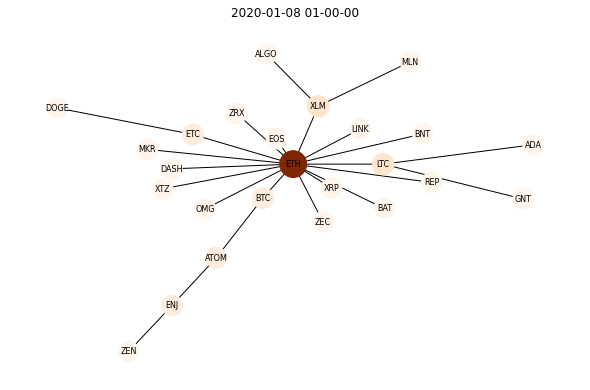

[7, 11, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1]


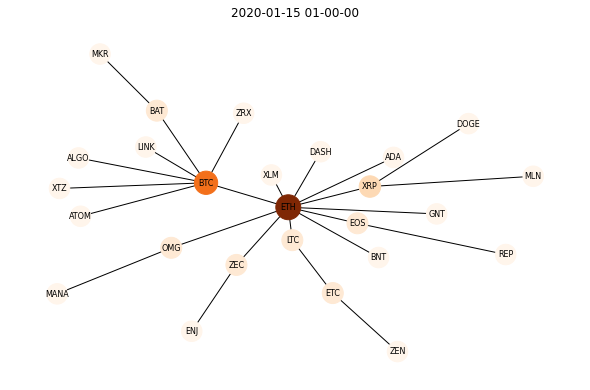

[9, 9, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 4, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1]


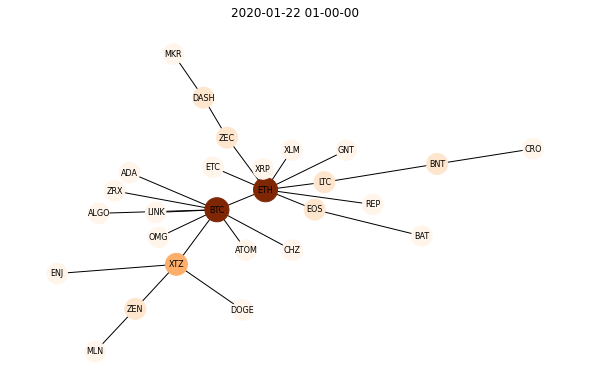

[10, 10, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


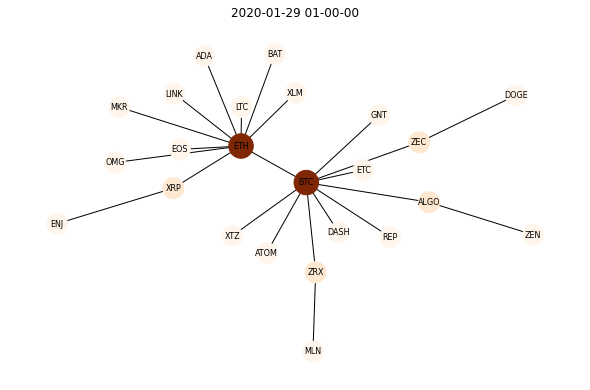

In [42]:
for k,mst in sorted(noisy_msts.items()):
    if k < "2020-02":
        print([x[1] for x in nx.degree(mst)])
        plot_mst(mst,k)

In [19]:
print(len(corrmats))
print(len(tickers))

99
57


In [93]:
degrees = np.zeros((len(corrmats), len(tickers)))

for i, (k,mst) in enumerate(sorted(msts.items())):
        #print(dict(nx.degree(mst)))
        #print(nx.get_node_attributes(mst,'ticker'))
        degree_per_ticker = dict(zip(nx.get_node_attributes(mst,'ticker').values(), dict(nx.degree(mst)).values()))
        #print(degree_per_ticker)
        for k,v in degree_per_ticker.items():
            degrees[i][tickers.index(k)] = v



degrees_mean = np.mean(degrees, axis=0)

In [94]:
degrees_df = pd.DataFrame(degrees)

rename_dict = {i:ticker for i,ticker in enumerate(tickers)}
degrees_df.rename(columns=rename_dict, inplace=True)

In [95]:
timestamps = [timestamp for timestamp in sorted(corrmats.keys())]
degrees_df.insert(0,'timestamps', timestamps)
degrees_df.set_index('timestamps')

BTC   ETH  XRP  XLM  DOGE  LTC  ADA  ZRX  LINK  MKR  \
timestamps                                                                  
2020-01-08 01-00-00   1.0  23.0  1.0  1.0   2.0  1.0  1.0  1.0   1.0  1.0   
2020-01-15 01-00-00   1.0  25.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0   
2020-01-22 01-00-00   1.0  23.0  1.0  1.0   2.0  1.0  1.0  1.0   1.0  1.0   
2020-01-29 01-00-00   1.0  21.0  1.0  1.0   2.0  1.0  1.0  1.0   1.0  1.0   
2020-02-05 01-00-00   1.0  23.0  1.0  1.0   2.0  1.0  1.0  1.0   1.0  1.0   
...                   ...   ...  ...  ...   ...  ...  ...  ...   ...  ...   
2021-10-27 01-00-00   1.0  54.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0   
2021-11-03 01-00-00   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  54.0  1.0   
2021-11-10 01-00-00   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  55.0  1.0   
2021-11-17 01-00-00   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  54.0  1.0   
2021-11-24 01-00-00  52.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0   

                     ...  SOL  XYO  ANKR  COTI  NKN  QNT  IOTX  MIR  TRB  GTC  
timestamps           ...                                                       
2020-01-08 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-15 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-22 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-29 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-02-05 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
...                  ...  ...  ...   ...   ...  ...  ...   ...  ...  ...  ...  
2021-10-27 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-03 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-10 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-17 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   0.0  1.0  1.0  1.0  
2021-11-24 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   0.0  1.0  1.0  1.0  

[99 rows x 57 columns]

<AxesSubplot:>

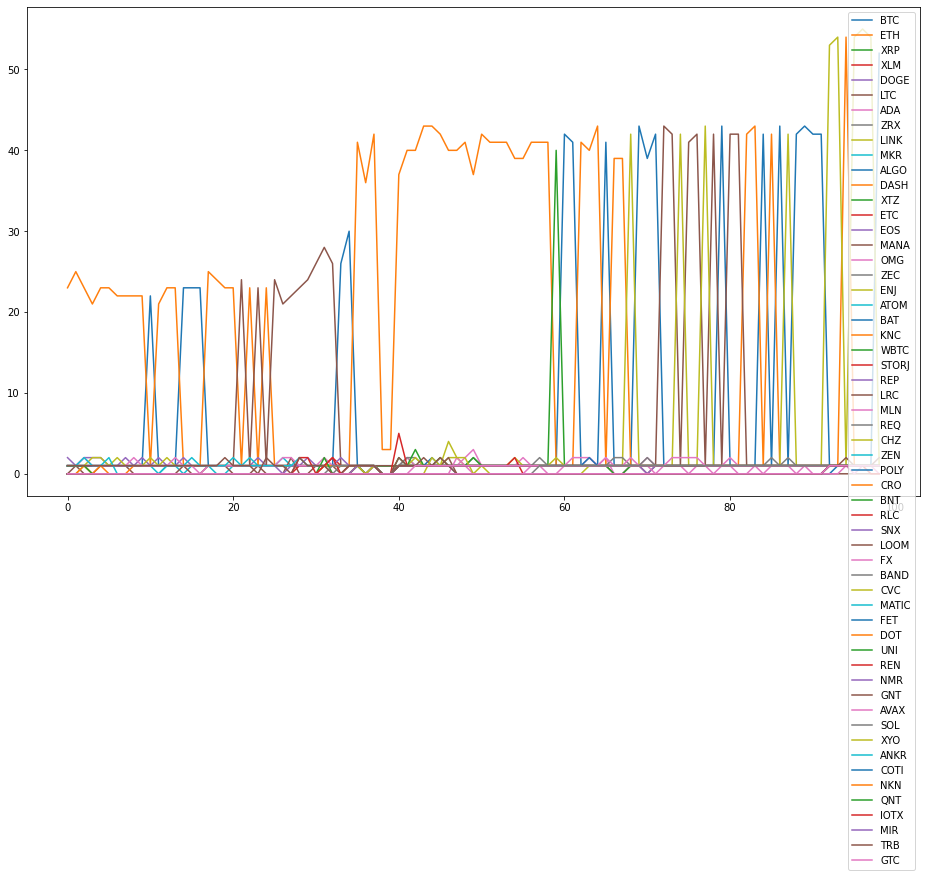

In [89]:
degrees_df.plot(figsize=(16,9))

In [60]:
degrees_noisy = np.zeros((len(corrmats), len(tickers)))

for i, (k,mst) in enumerate(sorted(noisy_msts.items())):
        #print(dict(nx.degree(mst)))
        #print(nx.get_node_attributes(mst,'ticker'))
        degree_per_ticker = dict(zip(nx.get_node_attributes(mst,'ticker').values(), dict(nx.degree(mst)).values()))
        #print(degree_per_ticker)
        for k,v in degree_per_ticker.items():
            degrees_noisy[i][tickers.index(k)] = v


In [61]:
degrees_noisy

array([[ 2., 16.,  1., ...,  0.,  0.,  0.],
       [ 7., 11.,  3., ...,  0.,  0.,  0.],
       [ 9.,  9.,  1., ...,  0.,  0.,  0.],
       ...,
       [13., 11.,  2., ...,  1.,  1.,  1.],
       [10.,  5.,  1., ...,  1.,  1.,  1.],
       [15.,  7.,  1., ...,  1.,  2.,  1.]])

In [62]:
degrees_noisy_df = pd.DataFrame(degrees_noisy)

rename_dict = {i:ticker for i,ticker in enumerate(tickers)}
degrees_noisy_df.rename(columns=rename_dict, inplace=True)

<AxesSubplot:>

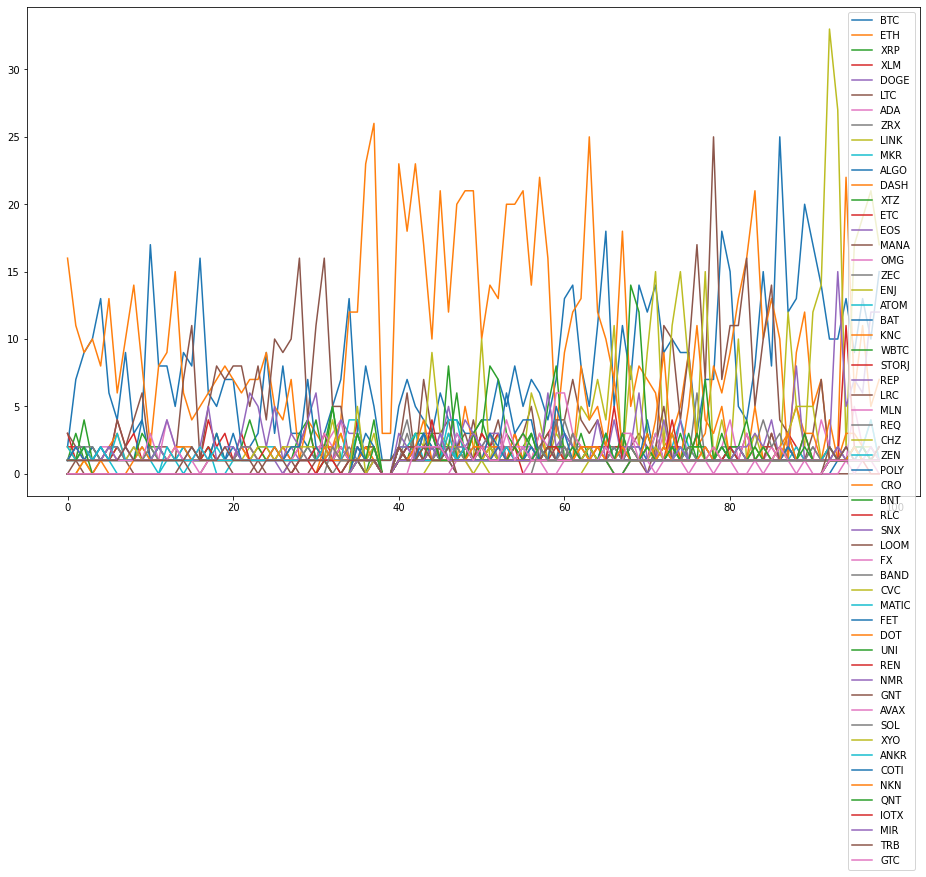

In [63]:
degrees_noisy_df.plot(figsize=(16,9))

In [52]:
from IPython.display import clear_output
from time import sleep

#plt.figure()
#for k,mst in sorted(noisy_msts.items()):
#    if k < "2021":
#        plot_mst(mst,k)
#        sleep(1)
#        clear_output(wait=True)
